## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import warnings

In [2]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

## Buscando dados

In [3]:
#Definindo período

inicio = datetime.datetime(2017, 1, 1)
fim = datetime.datetime(2022, 1, 1)

tickers = ['LREN3.SA', 'BBDC3.SA']
dados = pd.DataFrame()

for i in tickers:
    dados[i] = yf.download(i, start=inicio, end=fim)['Adj Close']

dados.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,LREN3.SA,BBDC3.SA
Date,,
2017-01-02,17.586409,13.395642
2017-01-03,18.126009,13.938509
2017-01-04,17.966408,13.933856
2017-01-05,17.799215,14.012918
2017-01-06,17.594013,14.119891


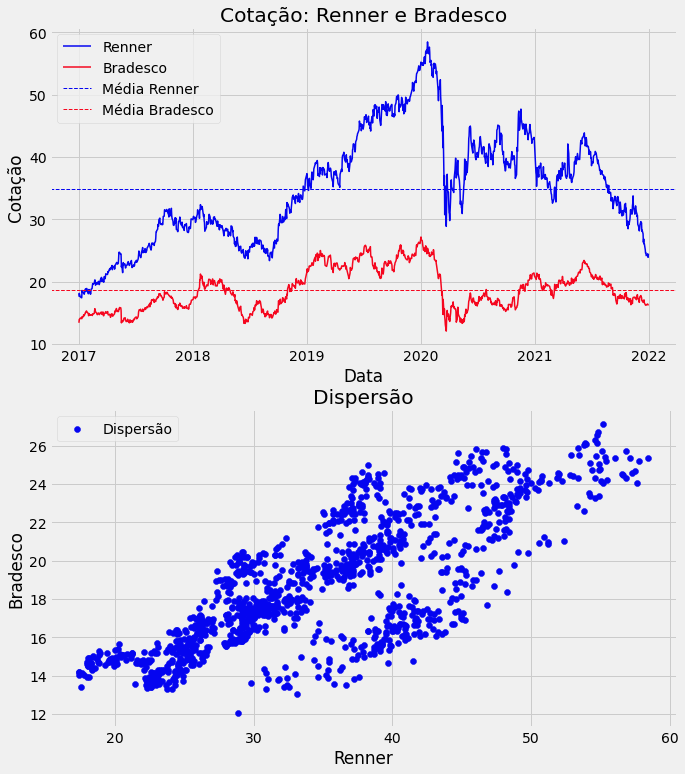

In [4]:
#Visualizando 

plt.figure(figsize=(10, 12));
plt.subplot(211)
x, = plt.plot(dados['LREN3.SA'], label='Renner', linewidth=1.5, color='#0505f0');
y, = plt.plot(dados['BBDC3.SA'], label='Bradesco', linewidth=1.5, color='#f5071f');
plt.axhline(y=dados['LREN3.SA'].mean(), label='Média Renner', linewidth=1.0, color='#0505f0', linestyle='--');
plt.axhline(y=dados['BBDC3.SA'].mean(), label='Média Bradesco', linewidth=1.0, color='#f5071f', linestyle='--');
plt.xlabel('Data');
plt.ylabel('Cotação');
plt.title('Cotação: Renner e Bradesco');
plt.legend(loc=2);

plt.subplot(212)
plt.scatter(x=dados['LREN3.SA'], y=dados['BBDC3.SA'], label='Dispersão', color='#0505f0');
plt.title('Dispersão');
plt.xlabel('Renner');
plt.ylabel('Bradesco');
plt.legend();

## Grau de cointegração

In [5]:
coint = dados.corr()
coint

,LREN3.SA,BBDC3.SA
LREN3.SA,1.000000,0.771725
BBDC3.SA,0.771725,1.000000


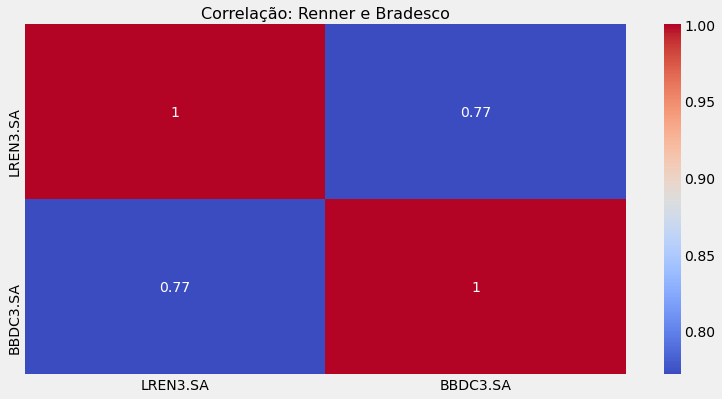

In [6]:
#Mapa de calor

plt.figure(figsize=(12, 6));
ax = plt.axes()
sns.heatmap(coint, ax = ax, annot=True, cmap='coolwarm')

ax.set_title('Correlação: Renner e Bradesco', fontsize=16)
plt.show()

## Regressão linear

In [7]:
#Biblioteca: Statsmodels

y = dados['BBDC3.SA']
x = dados['LREN3.SA']
'LREN3.SA'
X = sm.add_constant(x)
resultado = sm.OLS(y, X).fit()

print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:               BBDC3.SA   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1827.
Date:                Thu, 20 Jan 2022   Prob (F-statistic):          3.32e-246
Time:                        01:55:13   Log-Likelihood:                -2700.5
No. Observations:                1243   AIC:                             5405.
Df Residuals:                    1241   BIC:                             5415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7033      0.242     35.995      0.0

In [8]:
# Biblioteca: Sklearn

X = x.values.reshape(-1, 1)

reg = LinearRegression()
reg.fit(X, y)

r_square = np.round(reg.score(X, y), 3)
intercepto = np.round(reg.intercept_, 2)
coeficiente = np.round(reg.coef_[0], 2)

print(f'R² = {r_square}\nIntercepto = {intercepto}\nCoeficiente = {coeficiente}') 

R² = 0.596
Intercepto = 8.7
Coeficiente = 0.29


In [9]:
dados['Previsão'] = reg.predict(X)
dados['Erro'] = dados['BBDC3.SA'] - dados['Previsão']

dados.tail()

,LREN3.SA,BBDC3.SA,Previsão,Erro
Date,,,,
2021-12-23,24.170000,16.233063,15.637924,0.595139
2021-12-27,24.370001,16.402885,15.695306,0.707579
2021-12-28,24.459999,16.392897,15.721127,0.671769
2021-12-29,23.900000,16.273024,15.560459,0.712565
2021-12-30,24.440001,16.173126,15.715390,0.457737


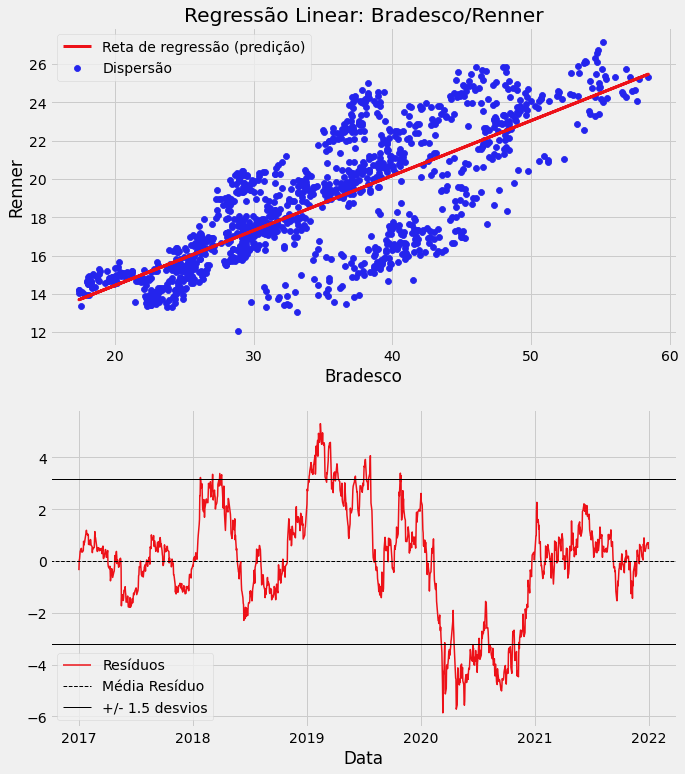

In [10]:
#Visualização

plt.figure(figsize=(10, 12));
plt.subplot(211)
plt.plot(x, dados['Previsão'], label='Reta de regressão (predição)', color='#ed1118', linewidth=3);
plt.scatter(x, y, label='Dispersão', color='#2424ed', linewidth=0.8);
plt.title('Regressão Linear: Bradesco/Renner');
plt.ylabel('Renner');
plt.xlabel('Bradesco');
#plt.text(0.05, 0.2, f'ŷ = {np.round(reg.intercept_, 0)} + {np.round(reg.coef_[0], 3)} * Rm');
#plt.text(0.10, -0.3, f'Beta: {np.round(reg.coef_[0], 4)}');
plt.legend();

plt.subplot(212)
plt.plot(dados['Erro'], linewidth=1.5, color='#ed1118', label='Resíduos');
#plt.title('Resíduos: Bradesco/Renner');
plt.axhline(y=dados['Erro'].mean(), label='Média Resíduo', linewidth=1.0, color='black', linestyle='--');
plt.axhline(y=(dados['Erro'].mean() + dados['Erro'].std() * 1.5), linewidth=1.0, color='black', linestyle='-');
plt.axhline(y=(dados['Erro'].mean() - dados['Erro'].std() * 1.5), label='+/- 1.5 desvios', linewidth=1.0, color='black', linestyle='-');
plt.xlabel('Data');
plt.legend(loc=3);

## Teste ADF (Augmented Dickey-Fuller)

In [11]:
x = dados['Erro'].values
adf = adfuller(x)
print(adf)

(-2.58600502181698, 0.09592437997109338, 5, 1237, {'1%': -3.4356474307506084, '5%': -2.8638793281844253, '10%': -2.5680154897465575}, 781.5042417247487)


In [12]:
print(f'Dickey-Fuller: {adf[0]:5f}')
print(f'P-valor: {adf[1]:5f}')
print('\n')
print('Valores críticos:\n')

for key, value in adf[4].items():
    print(f'{key}: {value}')

if adf[0] < adf[4]['5%']:
    print('Rejeitar a hipótese nula: a série é estacionária.')
else:
    print('\n')
    print('Não rejeitar a hipótese nula: a série é não-estacionária.')
    print('\n')

confidence = 1 - adf[1]
print(f'Confidence: {confidence:.2%}') 

Dickey-Fuller: -2.586005
P-valor: 0.095924


Valores críticos:

1%: -3.4356474307506084
5%: -2.8638793281844253
10%: -2.5680154897465575


Não rejeitar a hipótese nula: a série é não-estacionária.


Confidence: 90.41%


SCRIPT NÃO FINALIZADO!